In [1]:
import numpy as np
subh = np.loadtxt('../_data/subhalos.dat')

halo_mask, = np.where((subh[:,15]==0) & (subh[:,16]==0))

subh_name = subh[:,0][halo_mask]
subh_ind  = np.int_(subh_name)
# nsubh = len(subh_name)

print(subh_ind)

[ 0  1  3  4  5  6  7  9 20 21 22 27 28 31 33 35 36 37 38 39 41 42 45 46
 49 50 51 53 54 64 65 66 69 73 74 79 84 85 87 88 90 91 92 95 96]


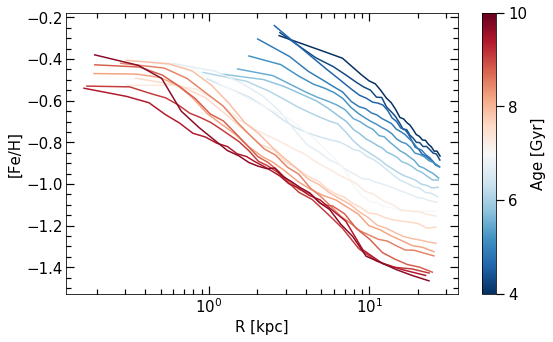

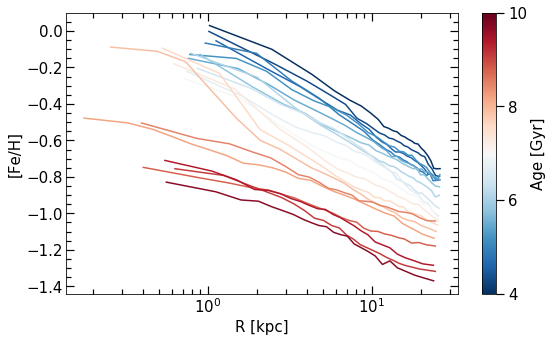

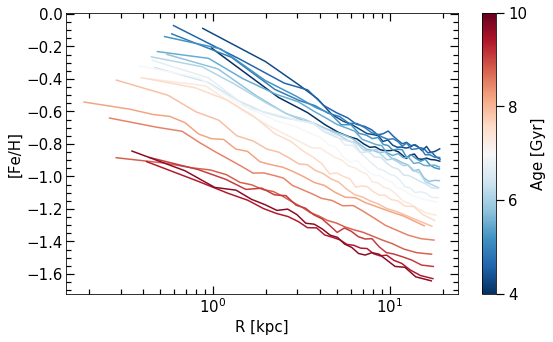

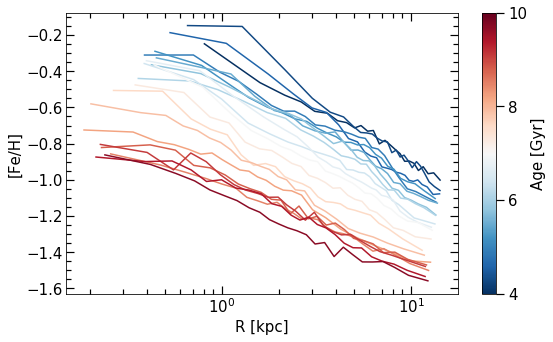

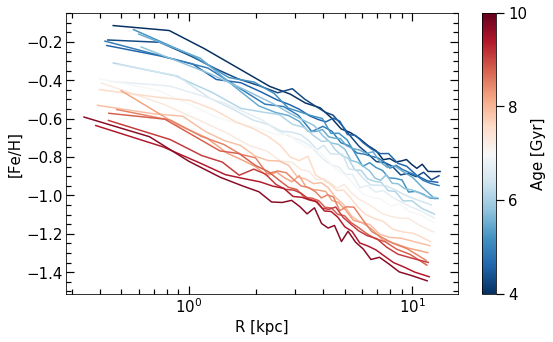

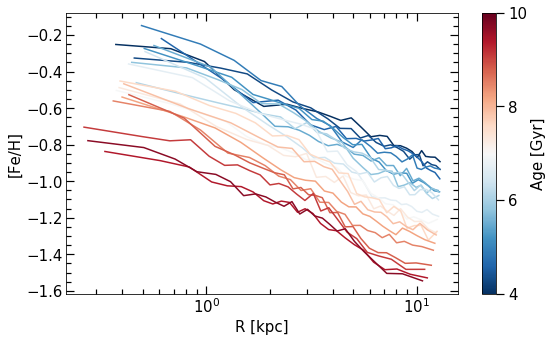

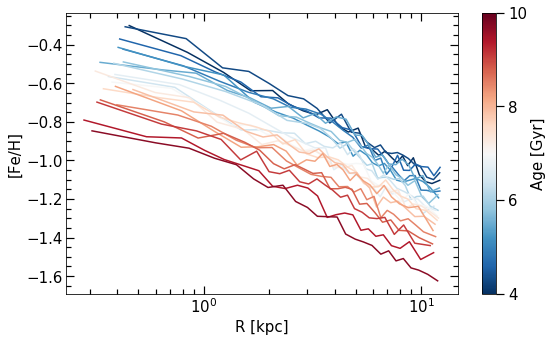

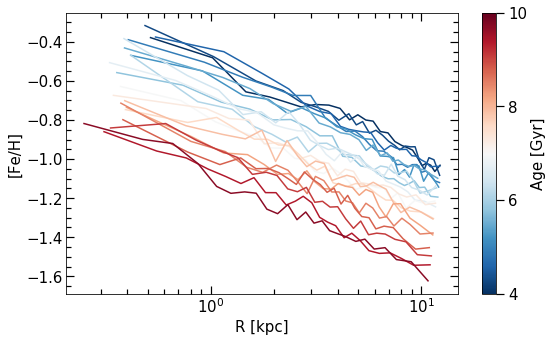

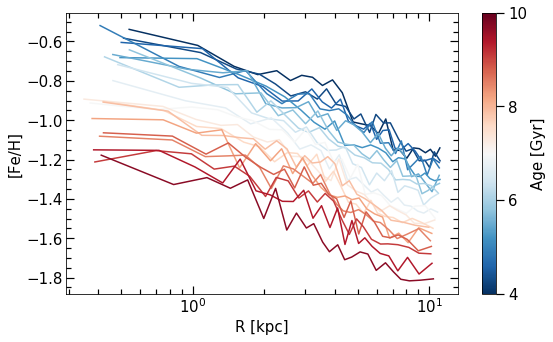

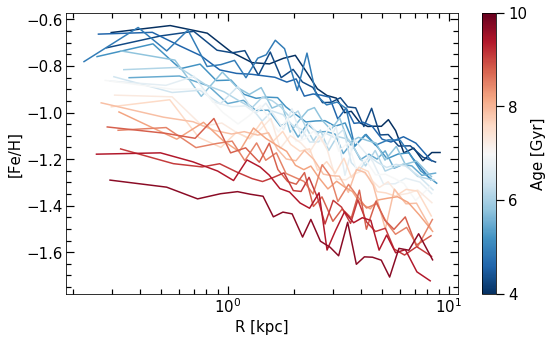

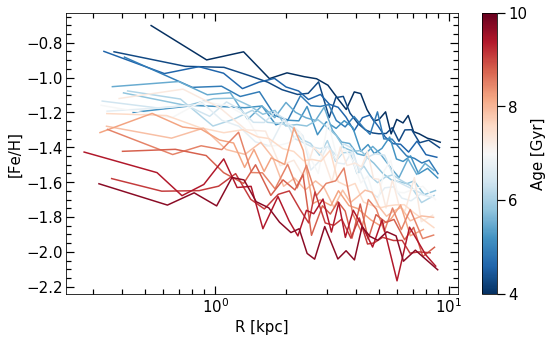

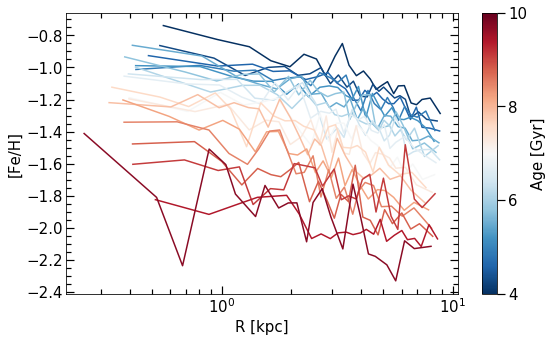

In [3]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import matplotlib as mpl
import metallicity_profile as metp

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/z/omarioni/gradients/_simulations/snap_127/'

for i in range(12):
    
    snap = h5py.File(path + 'subhalo_'+str('%03d'%ID[i])+'.h5py', 'r')

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    R200 = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    
    sft  = snap['/Str/FormationTime'][()]
    met  = snap['/Str/Metallicity'][()]
    
    aa,  = np.where(sft>0)
    age  = time.conv2(sft[aa], h, Om_L, Om_M)
    age  = np.nanmax(age) - age
    
    FeH_ = met[aa,8]/met[aa,0]
    FeH  = FeH_/0.0127

    xstr = pstr[aa,0]*aexp/h
    ystr = pstr[aa,1]*aexp/h
    zstr = pstr[aa,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[aa,0] *np.sqrt(aexp)
    v_y = vstr[aa,1] *np.sqrt(aexp)
    v_z = vstr[aa,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[aa]/h

    veloc,=np.where(rstr < 3)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,5)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn = np.sqrt(xn**2 + yn**2 + zn**2 )
    
    limit, = np.where(rn < 0.15*R200 )
    
    age_ = age[limit]

#     edades, = np.where((age_>4) & (age_<10))
    x_str = xn[limit]
    y_str = yn[limit]
    z_str = zn[limit]
    FeH   = FeH[limit]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)
    
    if j == 9:
        nb = 8
    else:
        nb = 20
    
    delta = (10.-4.)/nb
    rango = np.arange(4,10,delta)
    
    
    color_range = np.linspace(4,10,nb)
    norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap = 'RdBu_r')
    
    for i in rango:
        
        agelim = np.where((age_>i) & (age_<i+delta))
        
        R = np.sqrt(x_str[agelim]**2 + y_str[agelim]**2)
        z = z_str[agelim]
        FH = FeH[agelim]
        
        nbin = 25
        
        kk,  = np.where(FeH[agelim]>0)
        
        med, Fe_H = metp.met(R[kk],z[kk],np.log10(FH[kk]),nbin)

        ax.plot(med,Fe_H, ls='-',color = cmap.to_rgba(i))
    
    cbar = fig.colorbar(cmap,ticks=[4,6,8,10]) #pad=0.01)
    cbar.set_label('Age [Gyr]',fontsize=15)
    cbar.ax.tick_params( labelsize=15)
    cbar.ax.tick_params(length=8, width=1.2, which='major')
    
    ax.set_xscale('log')
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
    ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
    # ax.set_xlim(0,14)
    ax.set_ylabel('[Fe/H]',fontsize=15)
    ax.set_xlabel('R [kpc]',fontsize=15)
#     ax.legend(fontsize=15,frameon=False)

#     fig.savefig('../_imagenes/met_perfil/met_subh_'+str('%03d'%j)+'.png',dpi=100, xxbox_inches='tight')